## DSC170, Mini-Project # 4

This project will focus on __suitability analysis__ with raster data. Your tasks will be both conceptual-level and technical. 

There are three parts to this assignment.

1. At the conceptual level, you will define a suitability model of your choice, for an area of your choice (preferably San Diego, because we already have worked with some local data). Consult the lectures on map combination, and also see https://en.wikipedia.org/wiki/Suitability_model for a brief description of what a suitability model is. For example, you may be looking for best areas for community gardens. Such areas are often selected from underutilized land in residential land uses, with good soils, good drainage, accessible (not steep slope), etc. So you would be looking for areas with a specific type of land use/land cover, with an appropriate range of values of slope, etc. You may build additional criteria based on a range of precipitaiton values, whether the area is affected by wildfires, or has low levels of soil erosion, etc. Feel free to use the imagery layers we explored or mentioned during raster-focused lectures. One of the cells contained a list of about a dozen such layers available through AGOL - but feel free to find more. Also, feel free to download additional raster layers from elsewhere (an example in lecture demonstrates how to do this from the USGS image repository.)  You can use any __two__ of the map combination techniques discussed during lectures. You should identify the ones you use, and discuss any uncertainty issues associated with these specific map combination models. 

As the outcome of this part, you will need to: a) describe the suitability model you want to develop; b) identify the raster data layers you will use; and c) describe two of the map combination techniques you will use to derive the two suitablity maps, and their pros and cons.

2. The second part will involve implementing your suitability model using arcgis raster functions. Only local functions (in map algebra terms) are available through the UCSD Datahub, but there is a full support of raster analytics on the ESRI instance, including vector-to-raster conversion. Many of these functions are new and experimental! Examples of what works are in the lecture notebooks. Be creative! But also note that the functions are associated with raster services and depend on the version of the server a particular imagery layer is served from. See in the lecture notebooks how you can retrieve the version of the API supported by each layer, and which functions are supported in each API. 

3. The third part will be a brief write-up comparing the two output rasters generated for the suitability models using the two map combination techniques. 

The notebook should include documentation of the steps, as usually.

__How to submit.__ This MP4 template notebook can be fetched from NBGrader on the UCSD Datahub, but it won't be submitted through NBGrader (because most likely we won't be able to run it there anyway). This notebook can be also found in the "MP4_Winter20" group on the ESRI instance. Once you complete this assignment, please create a group for your team, share the notebook with that team, and invite the "DSC170Instructor" to this group. Your notebook name shall be in the form "mp4_name_of_team_member1_name_of_team_member2." Email to Sai when done.  

In [ ]:
# Names: Julian Yeh, Pete Sheurpukdi
#
# IDs: A13492068, A13604721
#

In [ ]:
# 1. Formulate a suitability model (markdown, about 100 words)


Our suitability model explores areas in San Diego that are suitable for windmills. We will take into account land cover type and surface slope to decide if it is a good place for a wind farm. Our hypothesis is that areas that are flat, or has small slope, and close to transmission lines are suitable. Furthermore, the area should be relatively "empty" in the sense that there are no other development or habitants.

In [1]:
# 2. Imports, etc.
import arcgis
from arcgis import GIS
from arcgis.raster.functions import *
from arcgis.geoanalytics.use_proximity import create_buffers
from arcgis.geoenrichment import enrich
from arcgis.features import GeoAccessor
from arcgis.raster.analytics import create_image_collection
from arcgis.raster.analytics import list_datastore_content
from arcgis.geocoding import geocode
from arcgis.raster import *
from IPython.display import display
import arcgis.raster

# Importing graphviz would be useful as we trace layer operations
#import graphviz

gis = GIS("https://ucsdnotebooks.demo.geocloud.com/portal/home/index.html", "cyyeh_UCSDOnline", "cyyeh_UCSDESRI123")
agol = GIS(username='cyyeh_ucsd5')

Enter password: ········


In [2]:
# 3. List imagery layers to be used in your model. This cell should contain layer definitions.

slope_lyr = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/Landscape_Modeler/USA_Slope/ImageServer", agol)

wind_binary_speed = agol.content.get('ea545ce04a1d48a0b70a08c7d8c67624')

trans_lines = agol.content.search('California Electric Transmission Line', outside_org=True)[0]

landcover_gap = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Landcover_GAP/ImageServer", agol)

In [3]:
# 4. Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)

# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_gcd = geocode(address='San Diego County, CA', out_sr=slope_lyr.extent['spatialReference'])

# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_gcd[0]['extent']

In [4]:
counties_item = agol.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[1]
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)

# Get the geometry of the San Diego County feature.
# We will use this geometry to extract the input data for the study area.
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference
print(study_area_geom)
print(study_area_extent)

{'rings': [[[-13038640.2378045, 3833847.56313313], [-13046623.4026057, 3857991.25757854], [-13037806.2894249, 3842709.77649226], [-13038242.9630011, 3852764.625192], [-13046507.9224498, 3860702.91542385], [-13052010.6888388, 3852918.36925318], [-13056142.698569, 3875572.5844261], [-13052752.1896589, 3880470.16217001], [-13060942.1288156, 3910110.69831699], [-13070037.4669952, 3926416.80993839], [-13090875.0407958, 3947789.6111035], [-13088850.2944962, 3956573.52304734], [-13083096.9145435, 3957334.95729047], [-13081091.6600256, 3960320.76148142], [-13081044.9604849, 3962992.62952016], [-13064742.9108947, 3963248.36768519], [-13065162.4628438, 3960696.59973376], [-13050808.7840634, 3954550.54729093], [-13050743.3943262, 3953033.60970995], [-13027843.751501, 3953125.99386067], [-13027782.6003613, 3952155.15750851], [-12922233.0458749, 3951969.51409108], [-12922139.2950188, 3905207.95747332], [-12924640.5058097, 3905050.31386036], [-12924969.1787687, 3844903.30316599], [-13038640.2378045,

In [ ]:
# 5. Name the two map combination techniques you will use to combine the data and describe their pros and cons (markdown) 

1. Exclusionary screening (0/1) (Binary)

2. Assign weights to each layer and sum pixels to get a "score".

In [5]:
# 6. Prepare your input layers for map combination: clip to AOI, remap/normalize, visualize the layers. Define what you mean to be suitable. 

# Colormaps
clrmap2 =  [[1, 230, 0, 0], [0, 38, 115, 0]]
clrmap5 =  [[9, 210, 15, 0], [7, 220, 75, 0], [5, 230, 135, 0], [3, 240, 195, 0], [1, 255, 255, 0]]
clrmap4 =  [[9, 210, 15, 0], [7, 220, 75, 0], [5, 230, 135, 0], [3, 240, 195, 0]]

Slope layer preparation

In [6]:
# Clipping slope

slope_lyr.extent = study_area_extent
slope_clip = clip(raster=slope_lyr, geometry=study_area_geom)

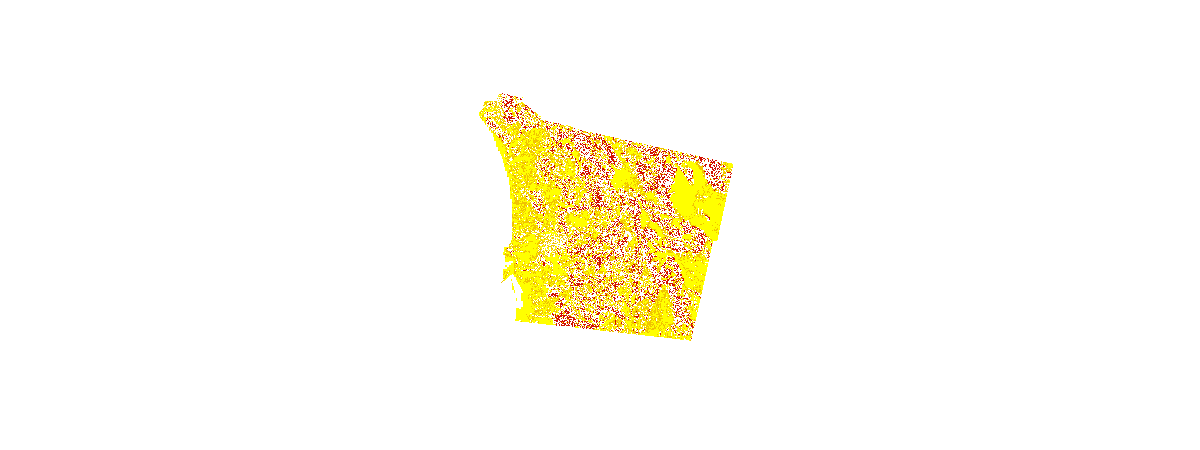

In [19]:
# Normalizing slope & visualizing
## Remapping degrees to 5 classes with value 10 being best and so on
slope_5 = remap(raster=slope_clip,
                  input_ranges=[0.0,4.5, 4.5,9.0, 9.0,18.0, 18.0,27.0, 27.0,60.0],
                  output_values=[1,3,6,9,12],  astype='U8')
slope_5_c = colormap(slope_5, colormap=clrmap5)

slope_5_c

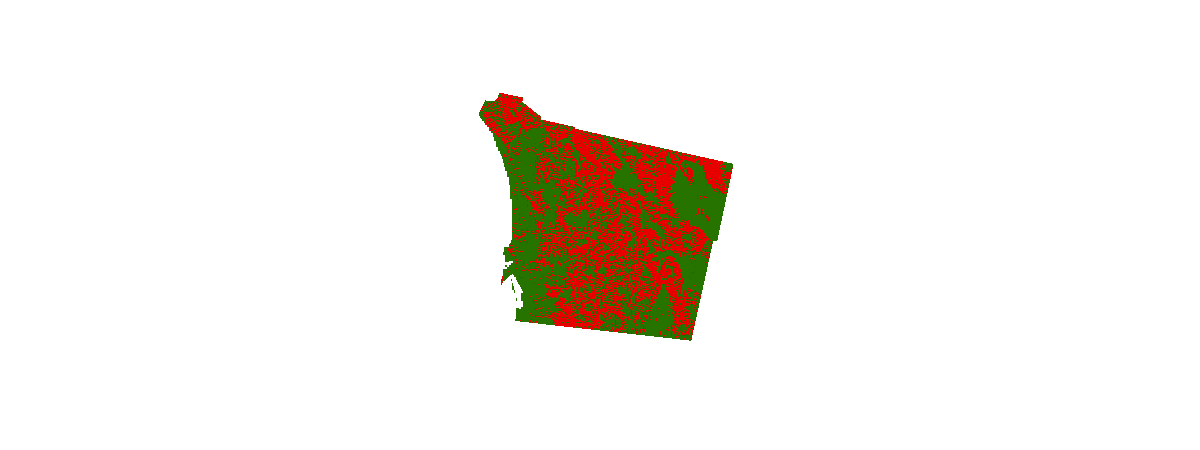

In [22]:
# Normalizing slope & visualizing
## Remapping degrees to binary classes
slope_2 = remap(raster=slope_clip,
                  input_ranges=[0.0,9.0, 9.0,60.0],
                  output_values=[0,1],  astype='U8')
slope_2_c = colormap(slope_2, colormap=clrmap2)

slope_2_c

Landcover layer preparation

Suitability definition: Ranking from high to low - Shrubland/Grassland, Semi-desert, forest/woodland, everything else

In [9]:
# Clipping landcover

landcover_gap.extent = study_area_extent
landcover_clip = clip(raster=landcover_gap, geometry=study_area_geom)

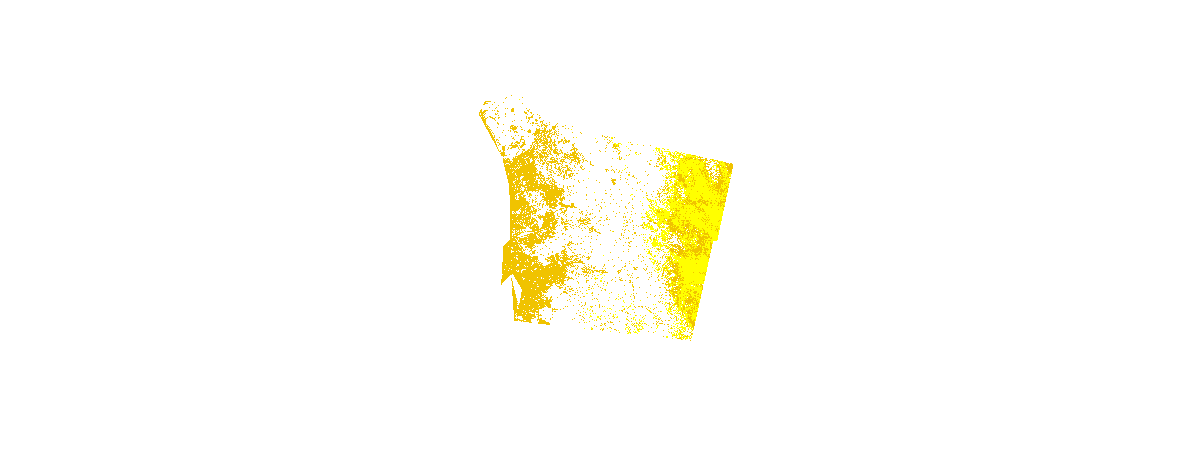

In [18]:
# Normalizing landcover & visualizing

landcover_4 = remap(raster=landcover_clip,
                  input_ranges=[0,290, 290,460, 460,500, 500,600],
                  output_values=[2, 0, 1, 3],  astype='U8')
landcover_4_c = colormap(landcover_4, colormap=clrmap5)

landcover_4_c

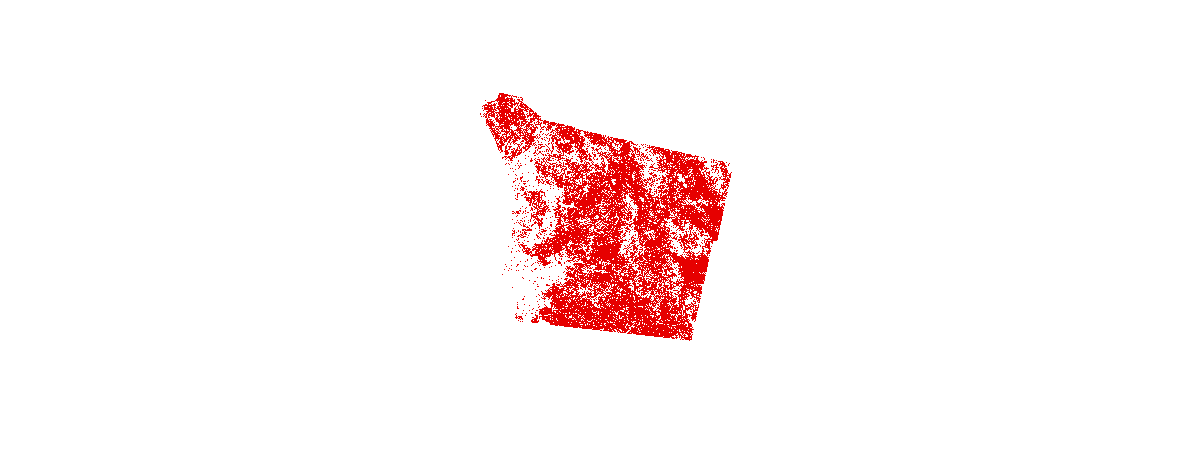

In [23]:
# Normalizing landcover & visualizing
## Remapping degrees to binary classes
landcover_2 = remap(raster=landcover_clip,
                  input_ranges=[290,500],
                  output_values=[1],  astype='U8')
landcover_2_c = colormap(landcover_2, colormap=clrmap2)

landcover_2_c

In [24]:
# 7a. Generate a composite raster layer for your first map combination technique
combo_1 = raster_calculator(rasters = [slope_2, landcover_2], input_names = ["a","b"], expression = "a*b", extent_type='FirstOf', cellsize_type='FirstOf', astype=None)
combo_1 = stretch(raster=combo_1, stretch_type='StdDev', dra='true')
m = agol.map('San Diego')
m.add_layer(combo_1)
#m.add_layer(trans_lines)
m.legend = True
m

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [20]:
# 7b. Generate a composite raster layer for your second map combination technique
combo_2 = raster_calculator(rasters = [slope_5, landcover_4], input_names = ["a","b"], expression = "(0.6*a)+(0.4*b)", extent_type='FirstOf', cellsize_type='FirstOf', astype=None)
combo_2 = stretch(combo_2, stretch_type='StdDev', dra=True)
m2 = agol.map('San Diego')
m2.add_layer(combo_2)
#m2.add_layer(trans_lines)
m2.legend = True
m2

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [ ]:
# 8. Compare the results, and describe how different combination techniques resulted in different outputs (or not.)
# 


Our results were the exclusionary screening raster layer and the weighted overlay layer. We first created a landcover index map and a slope index map. Using these two layers, we defined lower slope as being more suitable for wind farms as well as favoring shrublands and semi-deserts for the landcover type. The results from the two techniques are similar since the suitable (lighter) areas were pretty close. The difference is that by mapping the values to more than just two values, the map becomes more descriptive. We wanted to include a transmission lines layer and a wind speed layer; however, the wind speed layer wouldn't render on the map and we couldn't make a buffered transmission lines layer (it resulted in 'Job failed').

In [25]:
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 6
extracredit_timespent = 0